# Efficient RAW file generation by subsampling
This tutorial discusses generating high resolution synthetic data with smaller volumes by using lower sample rates.

If you have access to a GPU, it is highly recommended to install CuPy, which performs the equivalent NumPy array operations on the GPU (https://docs.cupy.dev/en/stable/install.html). This is not necessary to run raw voltage generation, but will highly accelerate the pipeline. Once you have CuPy installed, to enable GPU acceleration you must set `SETIGEN_ENABLE_GPU` to '1' in the shell or in Python via `os.environ`. It can also be useful to set `CUDA_VISIBLE_DEVICES` to specify which GPUs to use.

In [1]:
# !pip install cupy-cuda110

In [2]:
import os
os.environ['SETIGEN_ENABLE_GPU'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from astropy import units as u
import blimpy as bl

import setigen as stg

bshuf filter already loaded, skip it.
lz4 filter already loaded, skip it.
zfp filter already loaded, skip it.


In [4]:
# Sometimes it can be necessary to re-run this command for plots to show automatically
%matplotlib inline

Especially when using a high sampling rate like 3 GHz, `setigen`'s raw voltage pipeline can produce a *lot* of data, most of which is empty. Using the standard synthesis method, you can throw out information after it's generated, but that still requires generating an unnecessarily large amount of data beforehand. How can we cut down on unnecessary computation, but maintain time and frequency resolutions, not to mention signal processing conversions?

It turns out that as long as we're careful, we can reduce the sampling rate and the number of PFB branches and maintain the same overall structure of the data:

In [5]:
subsample_factor = 128

sample_rate = 3e9 // subsample_factor
num_taps = 8
num_branches = 1024 // subsample_factor

print(f'Max "num_chans" is {num_branches // 2}.')

Max "num_chans" is 4.


Note that the number of coarse channels to record `num_chans` has a reduced maximal value, since we are subsampling. An additional effect when reducing the data volume by a signficiant factor is that if you keep the `block_size` the same, you may end up writing more data when recording in `num_blocks` mode. This might be the desired behavior, but it's important to keep in mind. Since `record()` will generate enough data to fill out full blocks, if you additionally want to reduce the amount of data recorded, be sure to accordingly reduce `block_size`. 

So to test this out, let's add the same kinds of signals as we did in `05_raw_file_gen_snr.ipynb`, so that we can directly compare synthetic data products.

Setting up backend elements, then adding noise and a few signals:

In [6]:
fftlength = 1024
int_factor = 4
num_blocks = 1

digitizer = stg.voltage.RealQuantizer(target_fwhm=32,
                                      num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

requantizer = stg.voltage.ComplexQuantizer(target_fwhm=32,
                                           num_bits=8)

antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=6*u.GHz,
                              ascending=True,
                              num_pols=2)

block_size = stg.voltage.get_block_size(num_antennas=1,
                                        tchans_per_block=128,
                                        num_bits=8,
                                        num_pols=2,
                                        num_branches=num_branches,
                                        num_chans=num_branches//2,
                                        fftlength=fftlength,
                                        int_factor=int_factor)
rvb = stg.voltage.RawVoltageBackend(antenna,
                                    digitizer=digitizer,
                                    filterbank=filterbank,
                                    requantizer=requantizer,
                                    start_chan=0,
                                    num_chans=num_branches//2,
                                    block_size=block_size,
                                    blocks_per_file=128,
                                    num_subblocks=32)

# Add noise
for stream in antenna.streams:
    stream.add_noise(v_mean=0, 
                     v_std=1)
    
# Add signals
signal_level = stg.voltage.get_level(10, 
                                     rvb,
                                     num_blocks=num_blocks,
                                     length_mode='num_blocks',
                                     fftlength=fftlength)

for f_start in np.linspace(6003.1e6, 6003.9e6, 9):
    leakage_factor = stg.voltage.get_leakage_factor(f_start, rvb, fftlength)
    for stream in antenna.streams:
        level = stream.get_total_noise_std() * leakage_factor * signal_level
        stream.add_constant_signal(f_start=f_start, 
                                   drift_rate=0*u.Hz/u.s, 
                                   level=level)
    
rvb.record(output_file_stem='example_subsample',
           num_blocks=num_blocks, 
           length_mode='num_blocks',
           header_dict={'HELLO': 'test_value',
                        'TELESCOP': 'GBT'},
           verbose=False)

!rawspec -f $fftlength -t $int_factor -d . example_subsample

Blocks: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]     


working stem: example_subsample
opening file: example_subsample.0000.raw
opening file: example_subsample.0001.raw [No such file or directory]
output product 0: 128 spectra


Plotting the results:

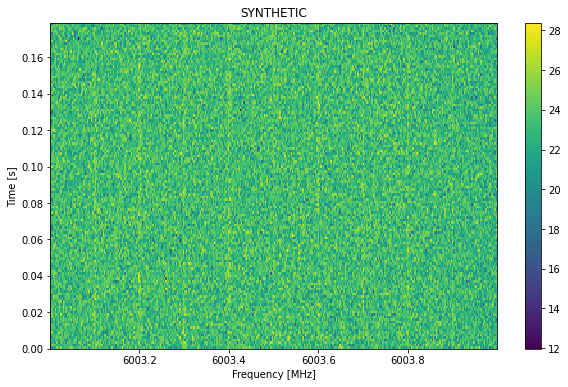

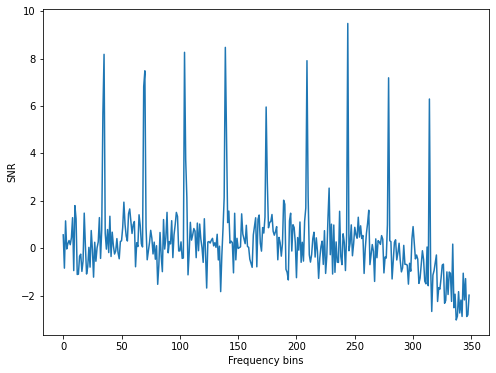

In [7]:
wf = bl.Waterfall('example_subsample.rawspec.0000.fil',
                  f_start=6003.0,
                  f_stop=6004.0)

plt.figure(figsize=(10, 6))
wf.plot_waterfall()
plt.show()

frame = stg.Frame(wf)

spectrum = stg.integrate(frame, normalize=True)

plt.figure(figsize=(8, 6))
plt.plot(spectrum)
plt.xlabel('Frequency bins')
plt.ylabel('SNR')
plt.show()

This looks very similar to the plot in `05_raw_file_gen_snr.ipynb`, as expected! We can also check the frame resolution:

In [8]:
frame.get_params()

{'fchans': 349,
 'tchans': 128,
 'df': 2861.02294921875,
 'dt': 0.001398101333333332,
 'fch1': 6003001213.07373,
 'ascending': True}